Desde la terminal:

```bash
pip install -r requirements.txt
````

*Cuaderno adaptado de [lightning.ai](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/09-normalizing-flows.html)*

In [1]:
import math
import os
import time
import urllib.request
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import HTML, display
from matplotlib.colors import to_rgb
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torch import Tensor
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # Para exportar
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Ruta a la carpeta donde se descargan/deberían descargarse los datasets
DATASET_PATH = os.environ.get("PATH_DATASETS", "data")
# Ruta a la carpeta donde se guardan los modelos preentrenados
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "modelos")

# Para reproducibilidad de los experimentos
pl.seed_everything(42)

# Para garantizar que todas las operaciones son deterministas en la GPU (si se utiliza) para reproducibilidad
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Obtener el dispositivo que se utilizará a lo largo de este cuaderno
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


Using device cpu


Descargar modelos pre-entrenados

In [2]:
# URL de Github de donde descargar los modelos
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial11/"
# Ficheros a descargar
pretrained_files = ["MNISTFlow_simple.ckpt", "MNISTFlow_vardeq.ckpt", "MNISTFlow_multiscale.ckpt"]
# Crear directorio checkpoint si aún no existe
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Descargar cada archivo si es que no existe ya.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Descargando {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Algo fue mal:\n",
                e,
            )

Descargando https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial11/MNISTFlow_simple.ckpt...
Descargando https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial11/MNISTFlow_vardeq.ckpt...
Descargando https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial11/MNISTFlow_multiscale.ckpt...


### UTILS

Funciones

In [3]:
# Convertir a enteros
def discretize(sample):
    return (sample * 255).to(torch.int32)

def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, Tensor) else len(imgs)
    is_int = imgs.dtype == torch.int32 if isinstance(imgs, Tensor) else imgs[0].dtype == torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y)
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in // 2, dtype=torch.float32), torch.zeros(c_in - c_in // 2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

### DATASET

Utilizaremos MNIST. A pesar de que es un dataset sencillo constituye un reto para modelos generativos explícitos ya que requiere la comprensión global de lo que es una imagen. Además, podemos juzgar fácilmente si las imágenes generadas proceden de la misma distribución que el conjunto de datos (es decir, representan dígitos reales), o no.

Para tratar mejor la naturaleza discreta de las imágenes, las transformamos de un rango de 0-1 a un rango de 0-255 como números enteros.

In [4]:
# Transformaciones aplicadas a cada imagen => convertirlas en un tensor y discretizarlas
transform = transforms.Compose([transforms.ToTensor(), discretize])

# Carga del conjunto de datos de entrenamiento. Se divide en una parte de entrenamiento y otra de validación
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Carga del conjunto de test
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# Dataloaders que utilizaremos más adelante
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 127515254.78it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 21500833.12it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 212502424.23it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2839548.18it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Seed set to 42


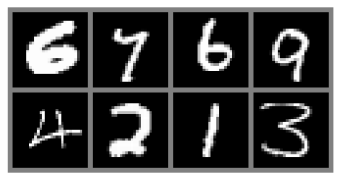

In [5]:
show_imgs([train_set[i][0] for i in range(8)])

### NORMALIZING FLOWS

Modelos generativos como los VAE y las redes GAN no aprenden explícitamente la función de densidad de los datos. 

Los normalizing flows modelan la verdadera distribución de datos y proporciona una estimación exacta de la verosimilitud (likelihood).

La principal diferencia con respecto a los VAE es que los flows utilizan funciones invertibles para convertir los datos de entrada a una representación latente z. 

z aquí tiene la misma dimensionalidad que los datos de entrada, a diferencia de los VAE, que reducen la dimensionalidad. La ventaja de esto es que al ser un mapeo invertible se pueden reconstruir los datos a partir de la representación latente sin ningún tipo de pérdida.

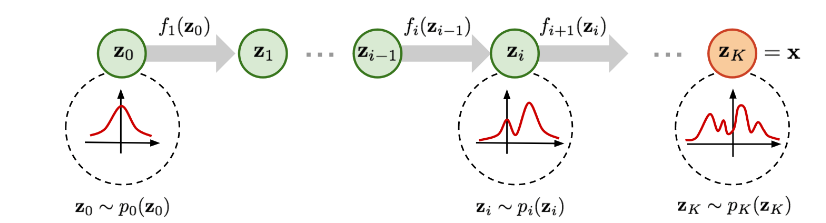

En este ejemplo queremos construir un normalizing flow que mapee una imagen de entrada a un espacio latente de igual tamaño:

![image-2.png](https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/09-normalizing-flows/image_to_gaussian.svg)

Como primer paso, implementaremos una plantilla de un normalizing flow en PyTorch Lightning. Durante entrenamiento y validación, un normalizing flow realiza una estimación de la densidad hacia adelante. Para ello, se aplican una serie de transformaciones sobre la entrada y se estima la probabilidad de la entrada determinando la probabilidad del punto z transformado dado un prior, y el cambio de volumen causado por las transformaciones. Durante la inferencia, se puede realizar tanto la estimación de la densidad como el muestreo de nuevos puntos invirtiendo las transformaciones. Por tanto, definimos una función *_get_likelihood* que realiza la estimación de la densidad, y *sample* para generar nuevos ejemplos. Las funciones training_step, validation_step y test_step utilizan _get_likelihood.

In [6]:
class ImageFlow(pl.LightningModule):
    def __init__(self, flows, import_samples=8):
        """ImageFlow.

        Args:
            flows: Lista de flows (each a nn.Module) que deben aplicarse.
            import_samples: Número de muestras de importancia a utilizar en test.

        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # distribución a priori para el espacio latente final
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Ejemplo de entrada para visualizar el grafo
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)

    def forward(self, imgs):
        # La función hacia adelante sólo se utiliza para visualizar el grafo
        return self._get_likelihood(imgs)

    def encode(self, imgs):
        # Dado un batch de imágenes, devuelve la representación latente z y ldj de las transformaciones
        # LDJ: Log-Determinant of the Jacobian: La matriz jacobiana representa las derivadas parciales de las funciones de transformación
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """Dado un batch de imágenes, devolver su likelihood.

        Si return_ll es True, esta función devuelve la log likelihood de la entrada. 
        En caso contrario, la métrica de salida es bits por dimensión (probabilidad logarítmica negativa escalada)

        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1, 2, 3])
        log_px = ldj + log_pz
        nll = -log_px
        # BPD: bits por dimensión
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """Muestreo de un batch del flujo."""
        # Sampleo del prior en el espacio latente
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)

        # Transformar z en x invirtiendo los flujos
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Los Normalizing flows se entrenan por maximum likelihood => retornar bpd
        loss = self._get_likelihood(batch[0])
        self.log("train_bpd", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log("val_bpd", loss)

    def test_step(self, batch, batch_idx):
        # Muestreo de importancia durante test => estimar la probabilidad M veces para cada imagen
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)

        # Para promediar las probabilidades, tenemos que pasar del espacio logarítmico al exp, y de nuevo al logarítmico.
        # Logsumexp proporciona una implementación para esto
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)

        # Calcular el bpd final
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()

        self.log("test_bpd", bpd)

La métrica estándar utilizada en los modelos generativos, y en particular en los normalizing flows, es bits por dimensión (bpd). Este enfoque está motivado desde una perspectiva de teoría de la información - describe cuántos bits necesitaríamos para codificar un sample concreto en nuestra distribución modelada. 

Cuantos menos bits se necesiten, más probable será el sample en nuestra distribución. Cuando comprobamos los bits por dimensión en el conjunto de test, podemos juzgar si nuestro modelo generaliza a nuevas muestras del conjunto de datos y no memorizó el conjunto de datos de entrenamiento. Para calcular la puntuación de bits por dimensión, podemos basarnos en la log-verosimilitud negativa y cambiar la base logarítmica (ya que los bits son binarios mientras que la NLL suele ser exponencial).

En el espacio de la imagen original, las imágenes de MNIST tienen una puntuación de bits por dimensión de 8 (necesitamos 8 bits para codificar cada píxel, ya que hay 256 valores posibles).

**Decuantizacion**

- TO-DO: Explicar para qué se utiliza la decuantización

In [7]:
class Dequantization(nn.Module):
    def __init__(self, alpha=1e-5, quants=256):
        """Dequantization.

        Args:
            alpha: pequeña constante que se utiliza para escalar la entrada original. 
            Previene tratar con valores muy cercanos a 0 y 1 al invertir la sigmoide.
            quants: Número de valores discretos posibles (normalmente 256 para una imagen de 8 bits)

        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants - 1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        # Aplica una transformación sigmoidea invertible
        if not reverse:
            ldj += (-z - 2 * F.softplus(-z)).sum(dim=[1, 2, 3])
            z = torch.sigmoid(z)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1 - z)).sum(dim=[1, 2, 3])
            z = torch.log(z) - torch.log(1 - z)
        return z, ldj

    def dequant(self, z, ldj):
        # Transforma valores discretos en volúmenes continuos
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

In [8]:
class VariationalDequantization(Dequantization):
    def __init__(self, var_flows, alpha=1e-5):
        """Variational Dequantization.

        Args:
            var_flows: lista de transformaciones que se utilizarán para modelar q(u|x)

        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1  # Condicionamos los flujos a x, es decir, a la imagen original

        # Prior de u es una distribución uniforme como antes
        # Como la mayoría de las transformaciones de flujo se definen en [-infinito,+infinito], aplicamos primero una sigmoidea inversa
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)

        # Después de los flows, aplicar u como en la descuantización estándar
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

**Capas coupling**

- TO-DO: explicar para qué y cómo se utilizan las capas coupling

In [9]:
class CouplingLayer(nn.Module):
    def __init__(self, network, mask, c_in):
        """Coupling layer en un normalizing flow.

        Args:
            network: A PyTorch nn.Module que modela mu y sigma. 
            La shape de salida debe ser el doble del tamaño del canal que la entrada.
            mask: Máscara binaria (0 o 1) donde 0 denota que el elemento debe ser transformado, 
            mientras que 1 significa que el latente será utilizado como entrada a la red.
            c_in: Número de canales de entrada

        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Registra la máscara como buffer ya que es un tensor que no es un parámetro,
        # sino que debe formar parte del estado de los módulos.
        self.register_buffer("mask", mask)

    def forward(self, z, ldj, reverse=False, orig_img=None):
        """Forward.

        Args:
            z: Entrada latente al flow
            ldj:
                El ldj actual de los flows anteriores. El ldj de esta capa se añadirá a este tensor.
            reverse: Si es True, se aplica la inversa de la capa.
            orig_img:
                Sólo se necesita en VarDeq. Permite condicionar el flow a una entrada externa (por ejemplo, la imagen original).

        """
        # Aplicar la red a la entrada enmascarada
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)

        # Estabilizar la salida de escala
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Salidas de máscara (sólo transformar la segunda parte)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Transformación Affine
        if not reverse:
            # Ya sea que primero cambiemos y luego escalemos, o al revés, 
            # es una elección de diseño, y por lo general no tiene un gran impacto
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1, 2, 3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1, 2, 3])

        return z, ldj

**Red neuronal a aplicar en las capas coupling**

In [10]:
class ConcatELU(nn.Module):
    """Activation function that applies ELU in both direction (inverted and plain).

    Allows non-linearity while providing strong gradients for any input (important for final convolution)

    """

    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)


class LayerNormChannels(nn.Module):
    def __init__(self, c_in, eps=1e-5):
        """This module applies layer norm across channels in an image.

        Args:
            c_in: Number of channels of the input
            eps: Small constant to stabilize std

        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(nn.Module):
    def __init__(self, c_in, c_hidden):
        """This module applies a two-layer convolutional ResNet block with input gate.

        Args:
            c_in: Number of channels of the input
            c_hidden: Number of hidden dimensions we want to model (usually similar to c_in)

        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2 * c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2 * c_hidden, 2 * c_in, kernel_size=1),
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):
    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """Module that summarizes the previous blocks to a full convolutional neural network.

        Args:
            c_in: Number of input channels
            c_hidden: Number of hidden dimensions to use within the network
            c_out: Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers: Number of gated ResNet blocks to apply

        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden), LayerNormChannels(c_hidden)]
        layers += [ConcatELU(), nn.Conv2d(2 * c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)

**Arquitectura final**

![image.png](https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/09-normalizing-flows/vanilla_flow.svg)

### ENTRENAMIENTO

In [11]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [
            CouplingLayer(
                network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
                c_in=1,
            )
            for i in range(4)
        ]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]

    for i in range(8):
        flow_layers += [
            CouplingLayer(
                network=GatedConvNet(c_in=1, c_hidden=32),
                mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
                c_in=1,
            )
        ]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [12]:
def train_flow(flow, model_name="MNISTFlow"):
    # PyTorch Lightning trainer
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, model_name),
        accelerator="auto",
        devices=1,
        max_epochs=200,
        gradient_clip_val=1.0,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    train_data_loader = data.DataLoader(
        train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8
    )
    result = None

    # Comprueba si existe un modelo preentrenado. En caso afirmativo, se carga y se omite el entrenamiento
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename, map_location=device)
        flow.load_state_dict(ckpt["state_dict"])
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(flow, train_data_loader, val_loader)

    # Probar el mejor modelo en el conjunto de validación y prueba si no se ha encontrado ningún resultado
    if result is None:
        val_result = trainer.test(flow, dataloaders=val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(flow, dataloaders=test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}

    return flow, result

Para no añadir más coste computacional cargamos modelos pre-entrenados

In [13]:
flow_dict = {"simple": {}, "vardeq": {}, "multiscale": {}}
flow_dict["simple"]["model"], flow_dict["simple"]["result"] = train_flow(
    create_simple_flow(use_vardeq=False), model_name="MNISTFlow_simple"
)
flow_dict["vardeq"]["model"], flow_dict["vardeq"]["result"] = train_flow(
    create_simple_flow(use_vardeq=True), model_name="MNISTFlow_vardeq"
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: False, used: False
TPU available:

Found pretrained model, loading...
Found pretrained model, loading...


In [14]:
flow_dict

{'simple': {'model': ImageFlow(
    (flows): ModuleList(
      (0): Dequantization()
      (1-8): 8 x CouplingLayer(
        (network): GatedConvNet(
          (nn): Sequential(
            (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): GatedConv(
              (net): Sequential(
                (0): ConcatELU()
                (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (2): ConcatELU()
                (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
            )
            (2): LayerNormChannels()
            (3): GatedConv(
              (net): Sequential(
                (0): ConcatELU()
                (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (2): ConcatELU()
                (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
            )
            (4): LayerNormChannels()
            (5): GatedConv(
        

### MODELADO DE LA DENSIDAD Y SAMPLING

**Resultados en cuanto a estimación de densidad**

In [15]:
table = [
    [
        key,
        "{:4.3f} bpd".format(flow_dict[key]["result"]["val"][0]["test_bpd"]),
        "{:4.3f} bpd".format(flow_dict[key]["result"]["test"][0]["test_bpd"]),
        "%2.0f ms" % (1000 * flow_dict[key]["result"]["time"]),
        "%2.0f ms" % (1000 * flow_dict[key]["result"].get("samp_time", 0)),
        "{:,}".format(sum(np.prod(p.shape) for p in flow_dict[key]["model"].parameters())),
    ]
    for key in flow_dict if "result" in flow_dict[key]
]

In [16]:
display(
    HTML(
        tabulate.tabulate(
            table,
            tablefmt="html",
            headers=["Model", "Validation Bpd", "Test Bpd", "Inference time", "Sampling time", "Num Parameters"],
        )
    )
)

Model,Validation Bpd,Test Bpd,Inference time,Sampling time,Num Parameters
simple,1.080 bpd,1.078 bpd,20 ms,18 ms,"556,312"
vardeq,1.045 bpd,1.043 bpd,26 ms,18 ms,"628,388"


Por lo que se ve en los resultados el uso de la descuantización variacional mejora a la descuantización estándar en términos de bits por dimensión. Aunque la diferencia con 0,04bpd no parece impresionante a primera vista, es un paso considerable para los modelos generativos (la mayoría de los modelos de última generación mejoran a los modelos anteriores en un rango de 0,02-0,1bpd).

**Sampling**

Seed set to 44


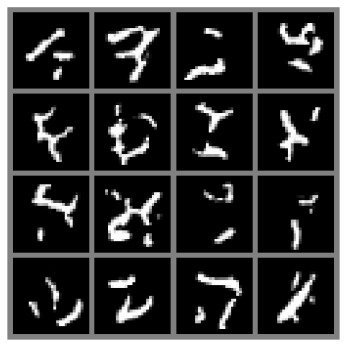

In [17]:
pl.seed_everything(44)
samples = flow_dict["vardeq"]["model"].sample(img_shape=[16, 1, 28, 28])
show_imgs(samples.cpu())

En este caso las muestras generadas distan mucho de ser perfectas. Aparentemente el modelo de sólo ha aprendido correlaciones locales y pequeñas.

- TO-DO: Explicar cómo se podría mejorar el modelo